# 1. Necessary Imports and Loading Dataset

In [111]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import os
import shutil
import random
from datetime import datetime

import tensorflow as tf
import seaborn as sns


# 2 Data Cleaning and Preprocessing

In [36]:
PATH = os.getcwd()
data_path = os.path.join(PATH, 'data')

### 2.1 Writing function for data cleaning and Transformation

In [39]:
#function to remove currency sign from price
def remove_currency(x):
    return x.split(' ')[1]

#function to remove character from vegetable names which will be used as column
def clean_columns(column):
    _list = []
    for x in column:
        a = x.lower().replace('(', ' ').replace(")", '').split(' ')
        a = '_'.join(a)
        _list.append(a)

    return _list


#function to get the date 
def get_date(path):
    return datetime.strptime(path.split('/')[-1].split('.')[0],"%m-%d-%Y")

#function to check if a dataset contains data or not
def valid_dataset(dataset):
    if dataset['commodities'].iloc[0] == "No data available in table":
        return False
    else:
        return True
        
#function to transform entire dataset into a row for new column
def transform(dataset, date):
    if valid_dataset(dataset):
        
        dataset['average'] = dataset['average'].apply(lambda a: remove_currency(a))    
        dataset = dataset[['commodities',  'average']]
        
        dataset = dataset.T
        dataset.columns = clean_columns(list(dataset.iloc[0]))
        dataset = dataset[1:]
        dataset.reset_index(drop = True)

        date = get_date(date)
        dataset['date'] = date
        dataset['no_data_available'] = False
        dataset.set_index('date', inplace = True, drop = True)
        return dataset
    else:
        date = get_date(date)
        throwaway_dataset = {'no_data_available': True, 'date': date}
        dataset = pd.DataFrame(throwaway_dataset, index = [1]).set_index('date')
        return dataset

### 2.2 Using the function we defined earlier to Transform all the dataset from last 10 years into one dataset

In [41]:
final_dataset = None
for i,data in enumerate(os.listdir(data_path)):
    file_path = os.path.join(data_path, data)
    if i == 0:
        dataset = pd.read_csv(file_path)
        dataset = transform(dataset, file_path)
        final_dataset = dataset
    else:
        dataset = pd.read_csv(file_path)
        dataset = transform(dataset, file_path)
        final_dataset = pd.concat([final_dataset, dataset], ignore_index = False, sort = False)

# 3. EDA and Visualizing the dataset

In [161]:
dataset = pd.read_csv('final_dataset')
dataset['date'] = pd.to_datetime(dataset['date'])
dataset = dataset.sort_values(by = 'date')

In [162]:
dataset.set_index('date', inplace = True)

In [163]:
#total number of days and number of vegetable class
number_of_days, number_of_vegetables = dataset.shape
print(f"The dataset contains information for {number_of_days} days and {number_of_vegetables} different type of vegetables")

The dataset contains information for 3865 days and 139 different type of vegetables


In [164]:
#checking na values
dataset.isna().sum().sort_values(ascending= False).head(30)

maize                  3864
musk_melon             3855
lentinula_edodes       3853
sweet_lime             3844
water_melon_dotted     3810
king_oyster            3788
mango_chousa           3745
onion_dry__chinese     3723
litchi_indian          3697
mango_calcutte         3686
sarifa                 3599
tree_tomato            3586
litchi_local           3485
mango_dushari          3443
bauhania_flower        3430
cabbage_terai          3330
sugarcane              3309
cabbage                3235
amla                   3233
strawberry             3157
kinnow                 3141
tomato_small_terai     3056
potato_red_mude        3054
orange_indian          3033
grapes_black           2959
tomato_small_indian    2948
carrot_terai           2934
mandarin               2908
avocado                2894
drumstick              2849
dtype: int64

In [183]:
#we have a total of 3865 records for different types of ve=egetables and most of the classes have nan entries. However, the dataset has price
# for most of the vegetable used frequently across nepali household and available during every season. We will only data for 30 popular classes

top_30 = dataset.isna().sum().sort_values().keys()[1:30]
df = dataset[top_30]
df.head(5)

,ginger,cauli_local,chilli_dry,banana,coriander_green,brd_leaf_mustard,bamboo_shoot,cabbage_local,french_bean_local,potato_red,...,tamarind,pumpkin,tomato_small_local,tofu,bottle_gourd,cucumber_local,water_melon_green,garlic_green,okara,bitter_gourd
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,95.0,24.0,235.0,45.0,65.0,19.0,137.0,23.0,57.0,26.0,...,77.0,17.0,33.0,65.0,33.0,38.0,55.0,58.0,117.0,85.0
2014-01-02,107.0,24.0,235.0,43.0,65.0,19.0,145.0,23.0,57.0,26.0,...,75.0,17.0,33.0,65.0,33.0,33.0,55.0,58.0,98.0,75.0
2014-01-03,105.0,27.0,235.0,45.0,65.0,19.0,140.0,23.0,63.0,26.0,...,77.0,17.0,33.0,65.0,33.0,68.0,55.0,58.0,105.0,85.0
2014-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-05,105.0,26.0,235.0,45.0,65.0,19.0,135.0,22.0,58.0,26.0,...,75.0,18.0,33.0,67.0,33.0,58.0,53.0,58.0,95.0,77.0


In [184]:
#checking for nulls and imputing them
df = df.ffill()
df.isna().any()

ginger                False
cauli_local           False
chilli_dry            False
banana                False
coriander_green       False
brd_leaf_mustard      False
bamboo_shoot          False
cabbage_local         False
french_bean_local     False
potato_red            False
onion_green           False
carrot_local          False
chilli_green          False
garlic_dry_chinese    False
brinjal_long          False
mushroom_kanya        False
lime                  False
capsicum              False
onion_dry__indian     False
tamarind              False
pumpkin               False
tomato_small_local    False
tofu                  False
bottle_gourd          False
cucumber_local        False
water_melon_green     False
garlic_green          False
okara                 False
bitter_gourd          False
dtype: bool

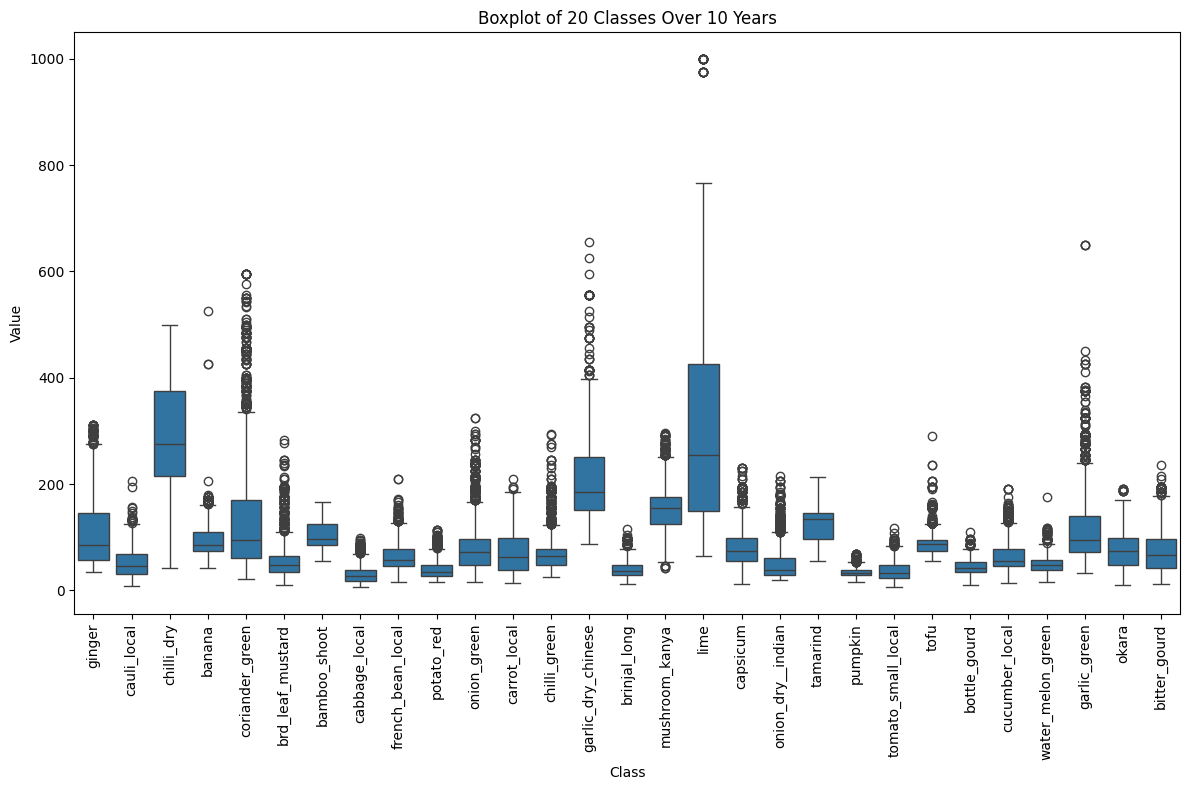

In [185]:
#checking for outliers and fixing them

df_reset = df.reset_index()

# Melt the dataframe to long format for plotting
df_melted = df_reset.melt(id_vars='date', var_name='Class', value_name='Value')

# Create the boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='Class', y='Value', data=df_melted)

plt.title('Boxplot of 20 Classes Over 10 Years')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [186]:
#removing outliers from the data

rolling_mean_15 = df.rolling(window=30, min_periods=1).mean()

# Define a function to detect outliers using IQR
def detect_outliers_iqr(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (df < lower_bound) | (df > upper_bound)

# Identify outliers in the dataframe
outliers = detect_outliers_iqr(df)

# Replace outliers with the rolling mean of the past 15 days
df = df.mask(outliers, rolling_mean_15)


False

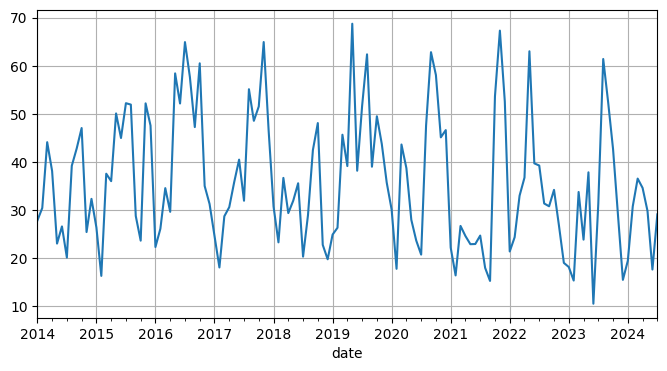

In [190]:

#visualizing a sample class 
period = slice("2014", "2024")
df_monthly = df.resample('ME').mean(numeric_only=True)
df_monthly['tomato_small_local'] = df_monthly['tomato_small_local'].interpolate()
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize = (8,4))
df_monthly['tomato_small_local'].plot(ax = ax, grid= True, legend = False)
plt.show()

# Creating Data for model Training

In [191]:
class_name = 'tomato_small_local'

In [192]:
tomato_data_daily = df[[class_name]]

In [193]:
#dividing the data into training period

data_train  = tomato_data_daily.loc['2014-01': '2021-12']
data_valid  = tomato_data_daily.loc['2022-01': '2023-07']
data_test  = tomato_data_daily.loc['2023-08':]


In [195]:
seq_length = 21
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    data_train.to_numpy(),
    targets = data_train[seq_length:],
    sequence_length = seq_length,
    batch_size = 32,
    shuffle = True,
    seed = 42    
)


valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    data_valid.to_numpy(),
    targets = data_valid[seq_length:],
    sequence_length = seq_length,
    batch_size = 32
)

In [196]:
for inputs, targets in train_ds.take(1):  # Take one batch from the dataset
    print("Inputs:\n", inputs.shape)  # Convert to NumPy arrays for better readability
    # print("\nTargets:\n", targets.numpy())

Inputs:
 (32, 21, 1)


In [197]:
test_ds = tf.keras.utils.timeseries_dataset_from_array(
    data_test.to_numpy(),
    targets = data_test[seq_length:],
    sequence_length=seq_length,
    seed = 42
)

# Training the model

In [198]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
tf.keras.layers.InputLayer(input_shape = [None, 1]),
tf.keras.layers.LSTM(128, return_sequences = False),
tf.keras.layers.Dense(1)
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])

history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
    callbacks=[early_stopping_cb])

Epoch 1/500


/home/rupesh/miniconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 16.7172 - mae: 17.2104 - val_loss: 4.8749 - val_mae: 5.3367
Epoch 2/500
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.4085 - mae: 5.8841 - val_loss: 4.1864 - val_mae: 4.6492
Epoch 3/500
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.7137 - mae: 6.1900 - val_loss: 5.7460 - val_mae: 6.2345
Epoch 4/500
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.1078 - mae: 7.5917 - val_loss: 4.2998 - val_mae: 4.7807
Epoch 5/500
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.9354 - mae: 6.4163 - val_loss: 5.6916 - val_mae: 6.1733
Epoch 6/500
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.8536 - mae: 7.3364 - val_loss: 5.8103 - val_mae: 6.2778
Epoch 7/500
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.5339 - mae: 8.0149 - val_loss: 5.8285 - val_mae: 6.3040
Epoch 8/500
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.8513 - mae: 8.3352 - val_loss: 5.6266 - val_mae: 6.1046
Epoch 9/500
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.1266 - mae: 7

# Model Evaluation

In [199]:
val_loss, val_mae = model.evaluate(valid_ds)
print(f"Validation MAE: {val_mae}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5350 - mae: 5.0030
Validation MAE: 4.649214744567871


In [201]:
test_loss, test_mae = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0566 - mae: 4.5260 
Test Loss: 3.8413877487182617
Test MAE: 4.306125640869141


In [202]:
predictions = model.predict(test_ds).flatten()
# predictions = np.pad(predictions, (15, 0), 'constant', constant_values=0)
padding = np.zeros(21)
predictions = np.concatenate((padding, predictions))
predictions.shape

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


(366,)

In [203]:
actual_values = tomato_data_daily.loc['2023-08':].to_numpy()

In [208]:
predictions.shape

(366,)

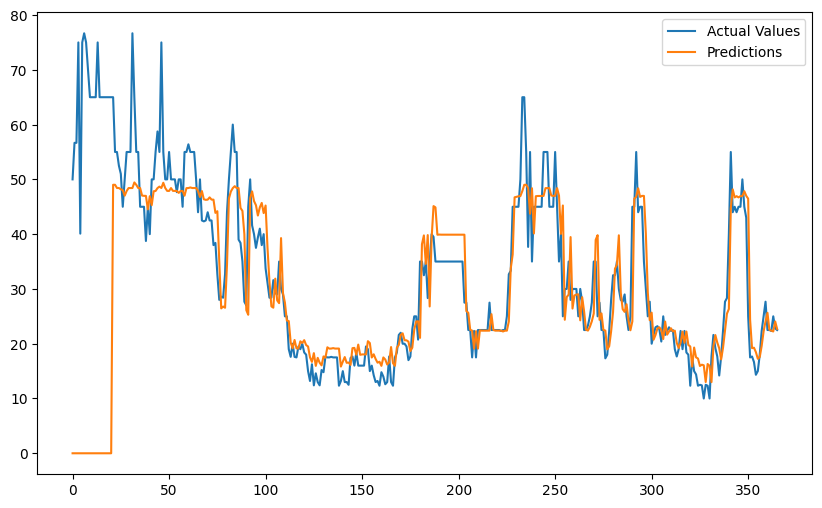

In [205]:
import matplotlib.pyplot as plt

# Assuming you have the actual values for the test set in `actual_values`
# predictions will be the output of model.predict()

plt.figure(figsize=(10, 6))
plt.plot(actual_values, label='Actual Values')
plt.plot(predictions, label='Predictions')
plt.legend()
plt.show()


In [21]:
tomato_data_daily

,tomato_small_local
date,
2014-01-01,33.00
2014-01-02,33.00
2014-01-03,33.00
2014-01-04,NaN
2014-01-05,33.00
...,...
2024-07-27,22.50
2024-07-28,22.33
2024-07-29,25.00


In [22]:
actual_values.shape

(366, 1)